In [2]:
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.linear_model import Lasso,Ridge,LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import xgboost as xgb
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_predict

In [3]:
def regressionMetrics(y, yhat):
    res = {
        'MSE': metrics.mean_squared_error(y, yhat),
        'RMSE': np.sqrt(metrics.mean_squared_error(y, yhat)),
        'MAE': metrics.mean_absolute_error(y, yhat),
        'R2': metrics.r2_score(y, yhat)
    }

    # Check if all values are > -1 to safely apply log
    if np.all(y > -1) and np.all(yhat > -1):
        rmsle = np.sqrt(metrics.mean_squared_log_error(y, yhat))
        res['RMSLE'] = rmsle
    else:
        res['RMSLE'] = 'Not applicable (values ≤ -1)'

    return res

# load the df for test

In [2770]:
df = pd.read_pickle('df_with_ev_ind.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2073 entries, 11 to 2083
Data columns (total 96 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             2073 non-null   datetime64[ns]
 1   SPY_return                     2073 non-null   float64       
 2   SPY_Volume                     2073 non-null   float64       
 3   AAPL                           2073 non-null   float64       
 4   MSFT                           2073 non-null   float64       
 5   GOOG                           2073 non-null   float64       
 6   GLD                            2073 non-null   float64       
 7   SLV                            2073 non-null   float64       
 8   ^TNX                           2073 non-null   float64       
 9   DX-Y.NYB                       2073 non-null   float64       
 10  JPY=X                          2073 non-null   float64       
 11  EUR=X                

## Drop duplicates / clean the data 

In [2771]:
df.reset_index(drop=True, inplace=True)
df = df.dropna()
df = df.drop_duplicates(subset='ds')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2071 entries, 0 to 2072
Data columns (total 96 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             2071 non-null   datetime64[ns]
 1   SPY_return                     2071 non-null   float64       
 2   SPY_Volume                     2071 non-null   float64       
 3   AAPL                           2071 non-null   float64       
 4   MSFT                           2071 non-null   float64       
 5   GOOG                           2071 non-null   float64       
 6   GLD                            2071 non-null   float64       
 7   SLV                            2071 non-null   float64       
 8   ^TNX                           2071 non-null   float64       
 9   DX-Y.NYB                       2071 non-null   float64       
 10  JPY=X                          2071 non-null   float64       
 11  EUR=X                 

,ds,SPY_return,SPY_Volume,AAPL,MSFT,GOOG,GLD,SLV,^TNX,DX-Y.NYB,...,March,April,May,June,July,August,September,October,November,December
0,2017-01-23,-0.269012,-10.789544,0.066658,0.350635,1.775112,0.643197,0.617668,-2.594240,-0.575734,...,0,0,0,0,0,0,0,0,0,0
1,2017-01-24,0.656459,20.971780,-0.091620,0.889458,0.556575,-0.449093,-0.429721,2.829789,0.189691,...,0,0,0,0,0,0,0,0,0,0
2,2017-01-25,0.802609,0.848583,1.592078,0.251904,1.432266,-0.824149,-0.739821,2.104413,-0.318884,...,0,0,0,0,0,0,0,0,0,0
3,2017-01-26,-0.073538,-6.178462,0.049234,0.926479,-0.421220,-0.927220,-1.055901,-0.594534,0.349894,...,0,0,0,0,0,0,0,0,0,0
4,2017-01-27,-0.086646,-13.127196,0.008170,2.349481,-1.062304,0.203069,1.820458,-1.076553,0.149434,...,0,0,0,0,0,0,0,0,0,0


# Add PE ratio

In [2772]:
pe = pd.read_csv('pe-ratio.csv')
pe = pe.iloc[1:]
pe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 1 to 340
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        331 non-null    object 
 1   shiler pe   331 non-null    object 
 2   PE          340 non-null    object 
 3   Unnamed: 3  0 non-null      float64
dtypes: float64(1), object(3)
memory usage: 10.8+ KB


In [2773]:
df_c = df.copy()
pe['date'] = pd.to_datetime(pe['date'])
pe.info()   
pe['month'] = pe['date'].dt.month
pe['year'] = pe['date'].dt.year
df_c['month'] = df_c['ds'].dt.month
df_c['year'] = df_c['ds'].dt.year

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 1 to 340
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        331 non-null    datetime64[ns]
 1   shiler pe   331 non-null    object        
 2   PE          340 non-null    object        
 3   Unnamed: 3  0 non-null      float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 10.8+ KB


In [2402]:
#pe['PE'].head(30)
df_c.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2071 entries, 0 to 2072
Columns: 102 entries, ds to year
dtypes: datetime64[ns](1), float64(68), int32(3), int64(29), int8(1)
memory usage: 1.6 MB


In [2774]:
#make the change on the copy df
df_c = pd.merge(df_c,pe[['month','year','PE','shiler pe']],how='left',on=['month','year'])
df_c.drop(['year', 'month'], axis=1, inplace=True)
df_c.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071 entries, 0 to 2070
Data columns (total 98 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             2071 non-null   datetime64[ns]
 1   SPY_return                     2071 non-null   float64       
 2   SPY_Volume                     2071 non-null   float64       
 3   AAPL                           2071 non-null   float64       
 4   MSFT                           2071 non-null   float64       
 5   GOOG                           2071 non-null   float64       
 6   GLD                            2071 non-null   float64       
 7   SLV                            2071 non-null   float64       
 8   ^TNX                           2071 non-null   float64       
 9   DX-Y.NYB                       2071 non-null   float64       
 10  JPY=X                          2071 non-null   float64       
 11  EUR=X            

## Convert the object types:

In [2775]:
df_c[['ds','PE']].tail(25)
for col in ['PE', 'shiler pe']:  # replace with your actual column names
    df_c[col] = (
        df_c[col]
        .astype(str)                    # ensure string type
        .str.replace(r'[^\d\.\-]', '', regex=True)  # remove all but digits, dot, minus
        .str.strip()                    # remove leading/trailing whitespace
    )
    df_c[col] = pd.to_numeric(df_c[col], errors='coerce')

    
df_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071 entries, 0 to 2070
Data columns (total 98 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             2071 non-null   datetime64[ns]
 1   SPY_return                     2071 non-null   float64       
 2   SPY_Volume                     2071 non-null   float64       
 3   AAPL                           2071 non-null   float64       
 4   MSFT                           2071 non-null   float64       
 5   GOOG                           2071 non-null   float64       
 6   GLD                            2071 non-null   float64       
 7   SLV                            2071 non-null   float64       
 8   ^TNX                           2071 non-null   float64       
 9   DX-Y.NYB                       2071 non-null   float64       
 10  JPY=X                          2071 non-null   float64       
 11  EUR=X            

## Use only the shiler pe 
Yields the best resaults

In [2776]:
merged = pd.merge(df, df_c[['ds','shiler pe']], on='ds', how='left') # add only the shiler pe column


df=merged
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071 entries, 0 to 2070
Data columns (total 97 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             2071 non-null   datetime64[ns]
 1   SPY_return                     2071 non-null   float64       
 2   SPY_Volume                     2071 non-null   float64       
 3   AAPL                           2071 non-null   float64       
 4   MSFT                           2071 non-null   float64       
 5   GOOG                           2071 non-null   float64       
 6   GLD                            2071 non-null   float64       
 7   SLV                            2071 non-null   float64       
 8   ^TNX                           2071 non-null   float64       
 9   DX-Y.NYB                       2071 non-null   float64       
 10  JPY=X                          2071 non-null   float64       
 11  EUR=X            

In [2777]:
lst =['Actual_GDP','Actual_CPI','Actual_PPI','Actual_unemployment rate','Actual_core_PCE','Actual_FOMC']
for col in lst:
    df[col] = df[col] *100

df['Actual_GDP'].head(20)




0    -500.0
1    -500.0
2    -500.0
3    -500.0
4       1.9
5    -500.0
6    -500.0
7    -500.0
8    -500.0
9    -500.0
10   -500.0
11   -500.0
12   -500.0
13   -500.0
14   -500.0
15   -500.0
16   -500.0
17   -500.0
18   -500.0
19   -500.0
Name: Actual_GDP, dtype: float64

# Have the rate as feature

does not help

In [ ]:
#df['Actual_FOMC'].replace({-500: np.nan}, inplace=True)
#df['Actual_FOMC'].fillna(method='ffill', inplace=True)
#df['Actual_FOMC'].fillna(0.75, inplace=True) # fill the first 3 values with 0.75
#df['Actual_FOMC'].head(20)

C:\Users\OMER\AppData\Local\Temp\ipykernel_24324\2527239491.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Actual_FOMC'].replace({-500: np.nan}, inplace=True)
C:\Users\OMER\AppData\Local\Temp\ipykernel_24324\2527239491.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

0     0.75
1     0.75
2     0.75
3     0.75
4     0.75
5     0.75
6     0.75
7     0.75
8     0.75
9     0.75
10    0.75
11    0.75
12    0.75
13    0.75
14    0.75
15    0.75
16    0.75
17    0.75
18    0.75
19    0.75
Name: Actual_FOMC, dtype: float64

In [2778]:
df_test = df.copy()

In [3023]:
df = df_test

## This df is to add feture to the model df

In [3024]:
df_add = pd.read_pickle('combined_cleaned_add.pkl')
df_add.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2084 entries, 2017-01-03 to 2025-04-16
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SPY_Close            2084 non-null   float64
 1   SPY_Volume           2084 non-null   int64  
 2   AAPL                 2084 non-null   float64
 3   MSFT                 2084 non-null   float64
 4   GOOG                 2084 non-null   float64
 5   GLD                  2084 non-null   float64
 6   SLV                  2084 non-null   float64
 7   ^TNX                 2084 non-null   float64
 8   DX-Y.NYB             2084 non-null   float64
 9   JPY=X                2084 non-null   float64
 10  EUR=X                2084 non-null   float64
 11  USO                  2084 non-null   float64
 12  UNG                  2084 non-null   float64
 13  BTC-USD              2084 non-null   float64
 14  CPER                 2084 non-null   float64
 15  ^VIX                

## Add support & resistance areas

In [3025]:
from scipy.signal import argrelextrema
spy_zones = df_add.copy()

# Use N = window size to define "local"
N = 10

# Find local maxima (resistance) and minima (support)
spy_zones['local_max'] = spy_zones['SPY_Close'].iloc[argrelextrema(spy_zones['SPY_Close'].values, np.greater_equal, order=N)[0]]
spy_zones['local_min'] = spy_zones['SPY_Close'].iloc[argrelextrema(spy_zones['SPY_Close'].values, np.less_equal, order=N)[0]]


# Define zone precision (e.g., $5 buckets)
zone_precision = 100
support_levels = spy_zones['local_min'].dropna().round(-int(np.log10(zone_precision)))
resistance_levels = spy_zones['local_max'].dropna().round(-int(np.log10(zone_precision)))

support_zones = support_levels.value_counts().loc[lambda x: x > 1].index.tolist()
resistance_zones = resistance_levels.value_counts().loc[lambda x: x > 1].index.tolist()


In [3026]:
# define your margins
margin_sup = 50.0    # dollars above support to trigger 1
margin_res = 50.0    # dollars below resistance to trigger -1

def support_signal(price):
    # compute (distance, support) for only those supports below or equal to price
    diffs = [(price - s, s) for s in support_zones if s <= price]
    if not diffs:
        return 0
    # pick the smallest positive distance
    nearest_diff, nearest_sup = min(diffs, key=lambda x: x[0])
    return 1 if nearest_diff <= margin_sup else 0

def resistance_signal(price):
    # compute (distance, resistance) for only those resistances above or equal to price
    diffs = [(r - price, r) for r in resistance_zones if r >= price]
    if not diffs:
        return 0
    nearest_diff, nearest_res = min(diffs, key=lambda x: x[0])
    return -1 if nearest_diff <= margin_res else 0

# apply to your DataFrame
spy_zones['SUPPORT_Signal']    = spy_zones['SPY_Close'].apply(support_signal)
spy_zones['RESISTANCE_Signal'] = spy_zones['SPY_Close'].apply(resistance_signal)

# quick check
print(spy_zones[['SPY_Close','SUPPORT_Signal','RESISTANCE_Signal']].tail(60))


              SPY_Close  SUPPORT_Signal  RESISTANCE_Signal
Date                                                      
2025-01-22  6086.370117               0                 -1
2025-01-23  6118.709961               0                  0
2025-01-24  6101.240234               0                  0
2025-01-27  6012.279785               0                  0
2025-01-28  6067.700195               0                 -1
2025-01-29  6039.310059               0                  0
2025-01-30  6071.169922               0                 -1
2025-01-31  6040.529785               0                  0
2025-02-03  5994.569824               0                  0
2025-02-04  6037.879883               0                  0
2025-02-05  6061.479980               0                 -1
2025-02-06  6083.569824               0                 -1
2025-02-07  6025.990234               0                  0
2025-02-10  6066.439941               0                 -1
2025-02-11  6068.500000               0                 

In [3027]:
spy_zones['yest_support_signal'] = spy_zones['SUPPORT_Signal'].shift(1)
spy_zones['yest_resistance_signal'] = spy_zones['RESISTANCE_Signal'].shift(1)
#spy_zones['2d_support_signal'] = spy_zones['SUPPORT_Signal'].shift(2)
#spy_zones['2d_resistance_signal'] = spy_zones['RESISTANCE_Signal'].shift(2)
spy_zones.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2084 entries, 2017-01-03 to 2025-04-16
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   SPY_Close               2084 non-null   float64
 1   SPY_Volume              2084 non-null   int64  
 2   AAPL                    2084 non-null   float64
 3   MSFT                    2084 non-null   float64
 4   GOOG                    2084 non-null   float64
 5   GLD                     2084 non-null   float64
 6   SLV                     2084 non-null   float64
 7   ^TNX                    2084 non-null   float64
 8   DX-Y.NYB                2084 non-null   float64
 9   JPY=X                   2084 non-null   float64
 10  EUR=X                   2084 non-null   float64
 11  USO                     2084 non-null   float64
 12  UNG                     2084 non-null   float64
 13  BTC-USD                 2084 non-null   float64
 14  CPER                  

In [3028]:
df_add = spy_zones

# Add some more fetures

In [3029]:
#df_add['SPY_Volume'].head(10)
df_add['vol_mean_30'] = df_add['SPY_Volume'].rolling(30).mean()
#df_add['vol_mean_30'].tail(30) 
df_add['vol_above_mean'] = (df_add['SPY_Volume'] > df_add['vol_mean_30']).astype(int)
df_add['vol_above_mean'].tail(25)

Date
2025-03-13    0
2025-03-14    0
2025-03-17    0
2025-03-18    0
2025-03-19    0
2025-03-20    0
2025-03-21    1
2025-03-24    0
2025-03-25    0
2025-03-26    0
2025-03-27    0
2025-03-28    0
2025-03-31    1
2025-04-01    0
2025-04-02    0
2025-04-03    1
2025-04-04    1
2025-04-07    1
2025-04-08    1
2025-04-09    1
2025-04-10    1
2025-04-11    0
2025-04-14    0
2025-04-15    0
2025-04-16    0
Name: vol_above_mean, dtype: int64

## Add DXY absolute value:

# Add volum above mean & absolute value of vix
Helps the model 

In [3030]:
to_add = df_add[['vol_above_mean','^VIX','SUPPORT_Signal','RESISTANCE_Signal','yest_support_signal','yest_resistance_signal']].copy()
#to_add = df_add[['vol_above_mean','^VIX','DX-Y.NYB']].copy()
#to_add = df_add[['vol_above_mean','^VIX','vol_mean_30']].copy()
to_add.reset_index(inplace=True)
to_add.rename(columns={'Date':'ds','^VIX': 'abs_vix'}, inplace=True)
#to_add.rename(columns={'Date':'ds','^VIX': 'abs_vix','DX-Y.NYB': 'DXY'}, inplace=True)


In [2986]:
to_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2084 entries, 0 to 2083
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ds                      2084 non-null   datetime64[ns]
 1   vol_above_mean          2084 non-null   int64         
 2   abs_vix                 2084 non-null   float64       
 3   DXY                     2084 non-null   float64       
 4   SUPPORT_Signal          2084 non-null   int64         
 5   RESISTANCE_Signal       2084 non-null   int64         
 6   yest_support_signal     2083 non-null   float64       
 7   yest_resistance_signal  2083 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(3)
memory usage: 130.4 KB


## Merge

In [3031]:
df = df.merge(to_add, on='ds', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071 entries, 0 to 2070
Columns: 103 entries, ds to yest_resistance_signal
dtypes: datetime64[ns](1), float64(70), int32(1), int64(30), int8(1)
memory usage: 1.6 MB


In [3032]:
print(df.columns.to_list())

['ds', 'SPY_return', 'SPY_Volume', 'AAPL', 'MSFT', 'GOOG', 'GLD', 'SLV', '^TNX', 'DX-Y.NYB', 'JPY=X', 'EUR=X', 'USO', 'UNG', 'BTC-USD', 'CPER', '^VIX', '^GDAXI', '^FTSE', '^RUT', '^N225', 'IEI', 'CNYUSD=X', '2Y_Yield', 'yield_curve', 'market_closed_count', 'yield_curve_term', 'high-low', 'before_high-low', 'SPY_Streak', 'SPY_AbsChange', 'day', 'Actual_GDP', 'Actual_nonfarm', 'Actual_CPI', 'Actual_PPI', 'Actual_unemployment rate', 'Actual_core_PCE', 'Actual_FOMC', 'CPI_vs_forecast', 'CPI_vs_previous', 'GDP_vs_forecast', 'GDP_vs_previous', 'PPI_vs_forecast', 'PPI_vs_previous', 'nonfarm_vs_forecast', 'nonfarm_vs_previous', 'unemployment rate_vs_forecast', 'unemployment rate_vs_previous', 'core_PCE_vs_forecast', 'core_PCE_vs_previous', 'FOMC_vs_forecast', 'FOMC_vs_previous', 'is_event', 'days_since_fomc', 'isr_holiday', 'event', 'EMA_20', 'EMA_50', 'EMA_200', 'EMA_20_50', 'EMA_50_200', 'EMA_50_diff', 'EMA_200_diff', 'SPY_RSI', 'RSI_rank', 'RSI_rank_2', 'std_price', '^VIX_dummy', '^VIX_rank

In [3033]:
y = df['SPY_return']
x = df.drop(['SPY_return', 'ds'], axis=1)
#'^VIX_rank'
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071 entries, 0 to 2070
Columns: 101 entries, SPY_Volume to yest_resistance_signal
dtypes: float64(69), int32(1), int64(30), int8(1)
memory usage: 1.6 MB


In [3034]:
split = int(len(y)*0.9)
x_train = x.iloc[:split]
x_test = x.iloc[split:]
y_train = y.iloc[:split]
y_test = y.iloc[split:]

In [3022]:
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import TimeSeriesSplit

# Parameters
best_w = None
best_mae = float('inf')

num_samples = len(y_train)
results = []


tscv = TimeSeriesSplit(n_splits=5)

# Test weight range from 1.0 to 3.0 in 0.1 steps
for w in np.arange(1.0, 3.1, 0.1):
    # Create sample weights linearly increasing from 1 to w
    weights = np.linspace(1, w, num_samples)
    weights = weights / np.mean(weights)  # Normalize to mean=1

    # Fit XGBoost with weights
    model = xgb.XGBRegressor(**{'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 200, 'reg_alpha': 0, 'subsample': 0.6, 'n_jobs': -1})
    model.fit(x_train, y_train, sample_weight=weights)

    # Predict and evaluate on test set
    predictions = model.predict(x_test)
    mae = mean_absolute_error(y_test, predictions)

    results.append((w, mae))
    print(f"w={w:.1f}, MAE={mae:.4f}")

    # Track best
    if mae < best_mae:
        best_mae = mae
        best_w = w

print(f"\n✅ Best weight with added slope w={best_w:.2f} with MAE={best_mae:.4f}")


w=1.0, MAE=0.2534
w=1.1, MAE=0.2596
w=1.2, MAE=0.2594
w=1.3, MAE=0.2620
w=1.4, MAE=0.2517
w=1.5, MAE=0.2525
w=1.6, MAE=0.2515
w=1.7, MAE=0.2508
w=1.8, MAE=0.2476
w=1.9, MAE=0.2541
w=2.0, MAE=0.2485
w=2.1, MAE=0.2554
w=2.2, MAE=0.2545
w=2.3, MAE=0.2546
w=2.4, MAE=0.2547
w=2.5, MAE=0.2511
w=2.6, MAE=0.2514
w=2.7, MAE=0.2479
w=2.8, MAE=0.2517
w=2.9, MAE=0.2508
w=3.0, MAE=0.2568

✅ Best weight with added slope w=1.80 with MAE=0.2476


In [3035]:
# Recreate sample weights using best_w = 3
num_samples = len(y_train)
weights = np.linspace(1, 2.5, num_samples)
weights = weights / np.mean(weights)  # Normalize to mean=1


xg_ind = xgb.XGBRegressor(**{'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 200, 'reg_alpha': 0, 'subsample': 0.6, 'n_jobs': -1})
xg_ind.fit(x_train, y_train,sample_weight=weights)
predicted_xg_ind2 = xg_ind.predict(x_test)
regressionMetrics(y_test,predicted_xg_ind2)

{'MSE': 0.12998973862857227,
 'RMSE': np.float64(0.36054089730372096),
 'MAE': 0.25270520740977637,
 'R2': 0.9207434434584661,
 'RMSLE': 'Not applicable (values ≤ -1)'}

Text(0, 0.5, 'Predictions')

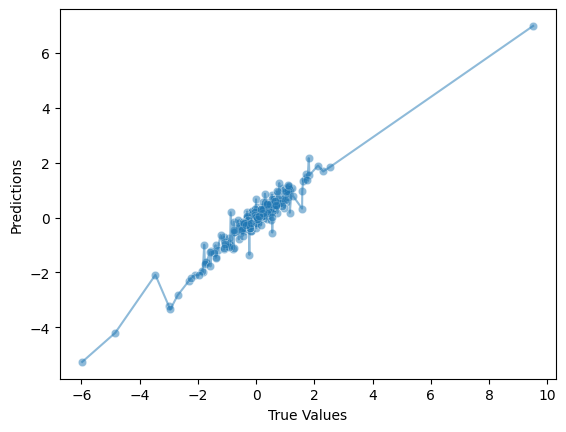

In [1767]:
sns.scatterplot(x=y_test, y=predicted_xg_ind2, alpha=0.5)
sns.lineplot(x=y_test, y=predicted_xg_ind2, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predictions')

## Best resaults so far

{'MSE': 0.1739106651896815,
 'RMSE': np.float64(0.41702597663656576),
 'MAE': 0.25650022213579016,
 'R2': 0.9010549166823064,
 'RMSLE': 'Not applicable (values ≤ -1)'}

# Feture selection

In [3036]:
model = xgb.XGBRegressor(n_estimators=200, random_state=42)
model.fit(x, y)

# Create DataFrame of importance
feature_importance = pd.DataFrame({
    'feature': x.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

# Select top N
selected_features = feature_importance[feature_importance['importance'] > 0.00]['feature'].tolist()

In [3037]:
l = ['SUPPORT_Signal', 'RESISTANCE_Signal', 'yest_support_signal', 'yest_resistance_signal']
#feature_importance.head(20)
print(feature_importance[['feature','importance']].loc[feature_importance['feature'].isin(l)].sort_values(by='importance', ascending=False))

                    feature  importance
100  yest_resistance_signal    0.000854
97           SUPPORT_Signal    0.000599
99      yest_support_signal    0.000590
98        RESISTANCE_Signal    0.000483


In [21]:
import seaborn as sns
#import matplotlib.pyplot as plt


In [1865]:
df['Actual_FOMC'].head(20)

0    -500.00
1    -500.00
2    -500.00
3    -500.00
4    -500.00
5    -500.00
6    -500.00
7    -500.00
8    -500.00
9       0.75
10   -500.00
11   -500.00
12   -500.00
13   -500.00
14   -500.00
15   -500.00
16   -500.00
17   -500.00
18   -500.00
19   -500.00
Name: Actual_FOMC, dtype: float64

Text(0.5, 0, 'Importance')

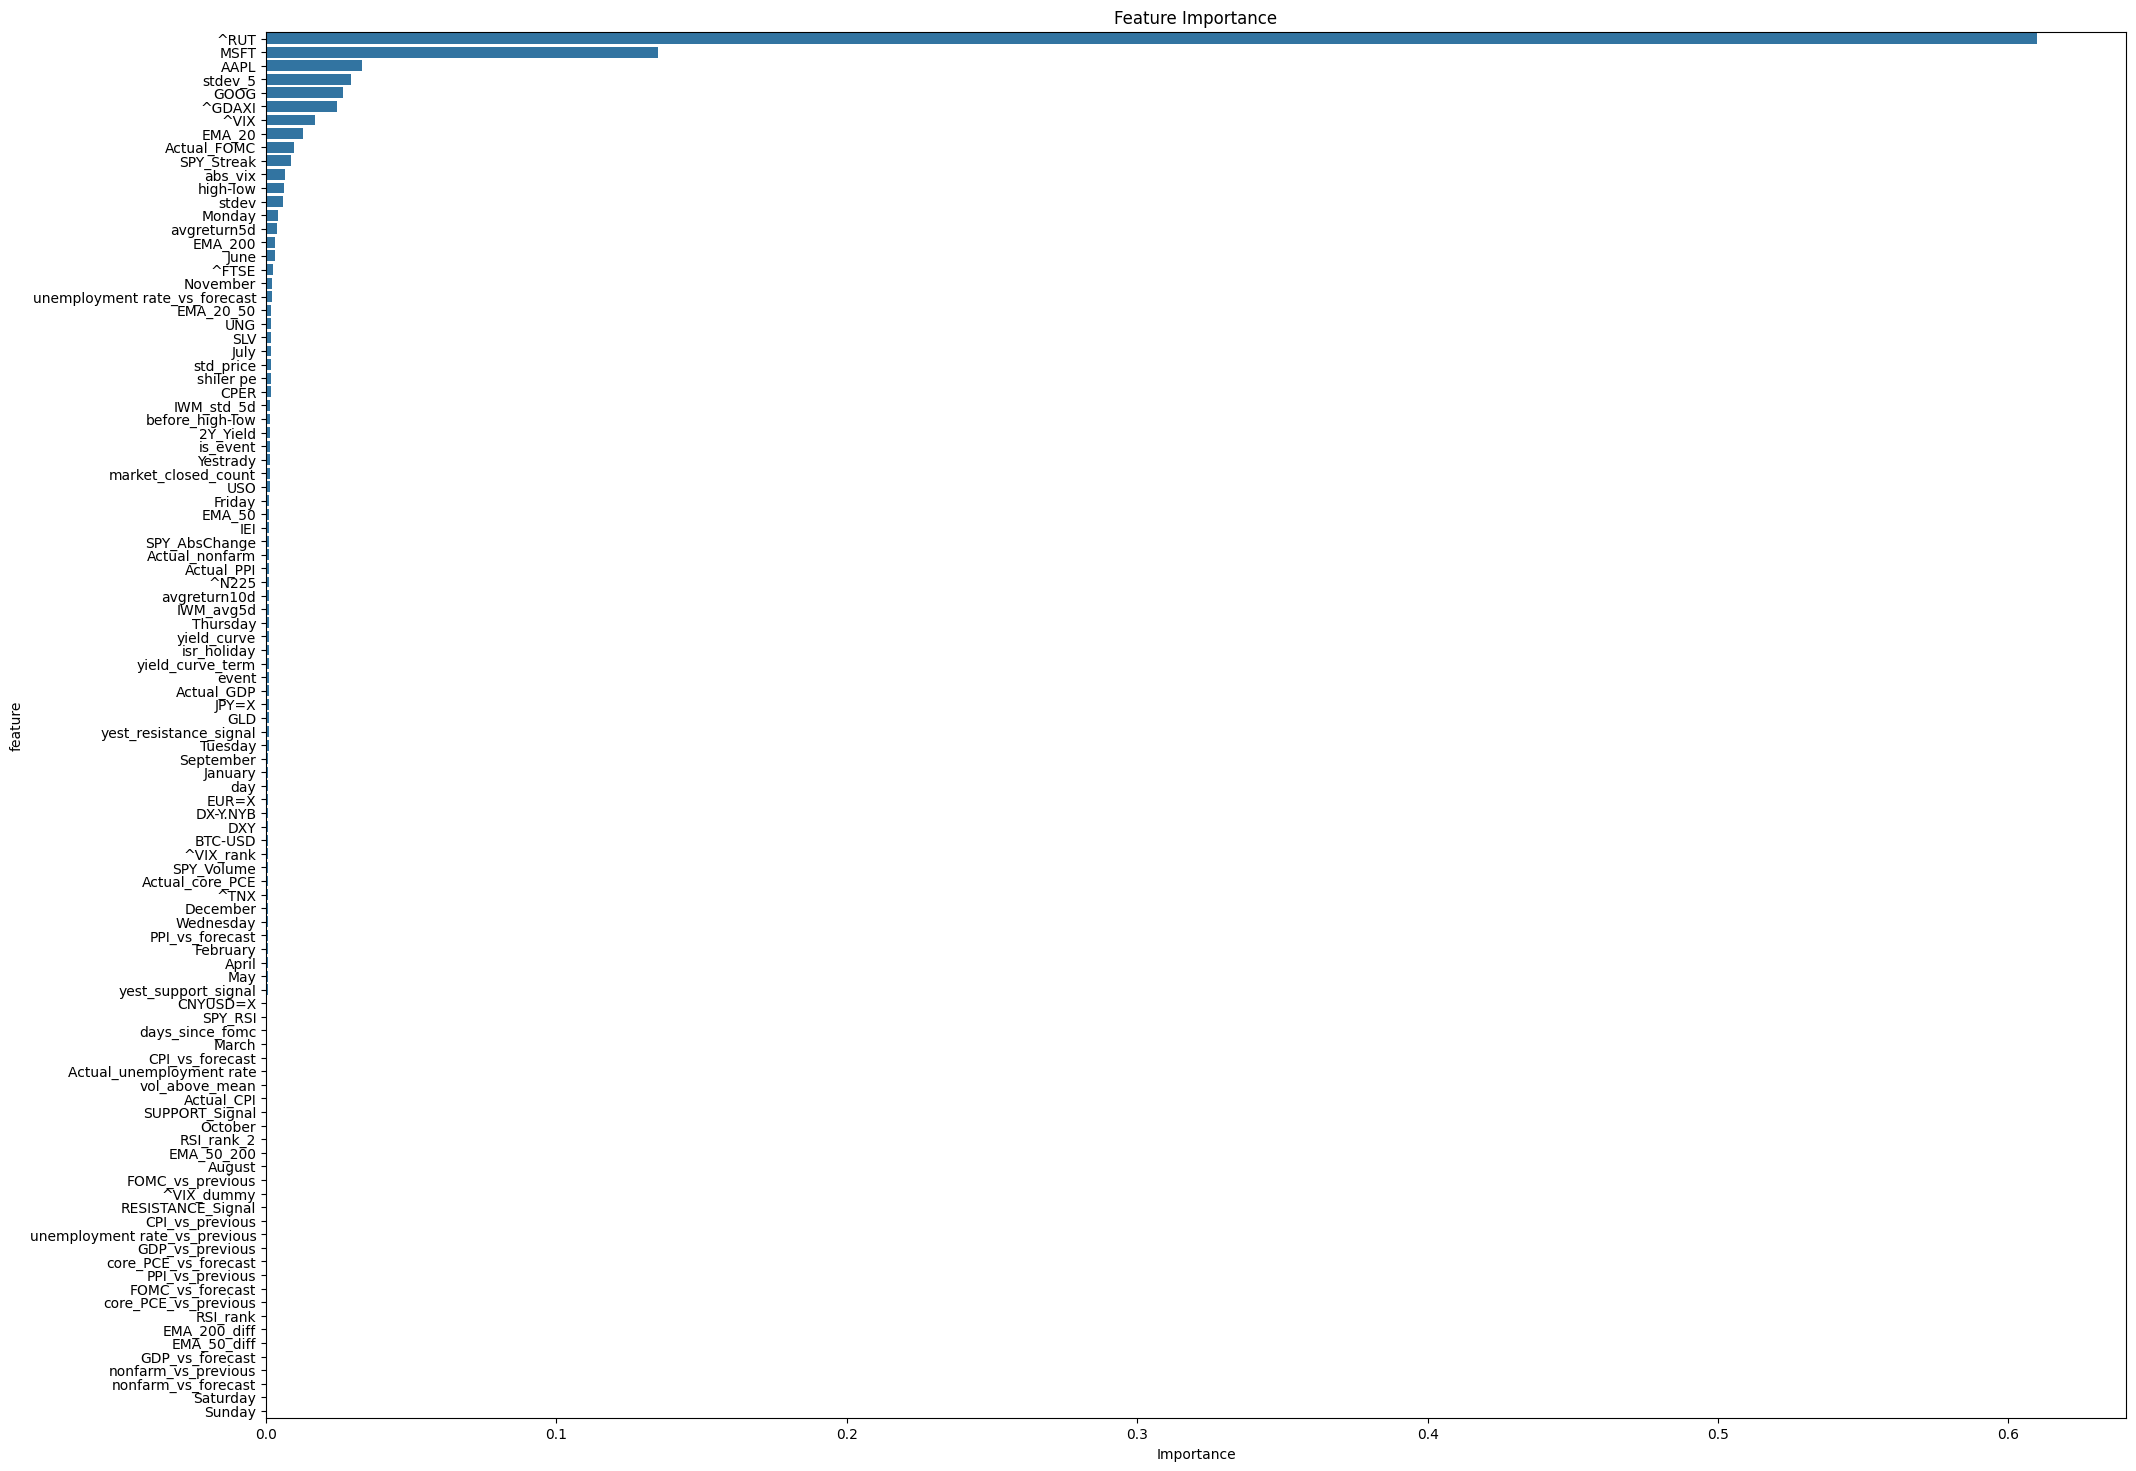

In [3014]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(24, 18))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance')
plt.xlabel('Importance')

In [2012]:
df['SPY_RSI'].head()

0    54.669773
1    61.857468
2    63.926955
3    63.965540
4    59.510150
Name: SPY_RSI, dtype: float64

In [373]:
print(len(selected_features))

81


In [3038]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, x, y, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()[::-1]
important_features = x.columns[sorted_idx[:38]] # 38 is the number that yields the best resaults 
print(important_features)

Index(['^RUT', 'MSFT', 'AAPL', '^VIX', 'GOOG', 'stdev_5', 'EMA_20', 'abs_vix',
       'avgreturn5d', 'high-low', 'SPY_Streak', '^GDAXI', 'stdev', 'SLV',
       '^FTSE', 'EMA_200', 'SPY_Volume', 'std_price', 'IWM_avg5d', 'UNG',
       'CPER', '^N225', 'JPY=X', 'before_high-low', 'shiler pe', 'GLD',
       'SPY_AbsChange', 'EMA_50', 'USO', 'BTC-USD', 'Yestrady', 'IWM_std_5d',
       'EUR=X', 'DX-Y.NYB', 'CNYUSD=X', 'avgreturn10d', 'yield_curve',
       '2Y_Yield'],
      dtype='object')


In [3068]:
important_features = x.columns[sorted_idx[:55]] # 38 is the number that yields the best resaults 
print(important_features)

Index(['^RUT', 'MSFT', 'AAPL', '^VIX', 'GOOG', 'stdev_5', 'EMA_20', 'abs_vix',
       'avgreturn5d', 'high-low', 'SPY_Streak', '^GDAXI', 'stdev', 'SLV',
       '^FTSE', 'EMA_200', 'SPY_Volume', 'std_price', 'IWM_avg5d', 'UNG',
       'CPER', '^N225', 'JPY=X', 'before_high-low', 'shiler pe', 'GLD',
       'SPY_AbsChange', 'EMA_50', 'USO', 'BTC-USD', 'Yestrady', 'IWM_std_5d',
       'EUR=X', 'DX-Y.NYB', 'CNYUSD=X', 'avgreturn10d', 'yield_curve',
       '2Y_Yield', 'IEI', 'SPY_RSI', 'day', 'days_since_fomc', '^TNX',
       'Actual_FOMC', 'Monday', 'Wednesday', '^VIX_rank', 'vol_above_mean',
       'July', 'November', 'Tuesday', 'Actual_PPI', 'yest_support_signal',
       'is_event', 'Thursday'],
      dtype='object')


In [3069]:
y_s = df['SPY_return']
x_s = df[important_features]
x_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071 entries, 0 to 2070
Data columns (total 55 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ^RUT                 2071 non-null   float64
 1   MSFT                 2071 non-null   float64
 2   AAPL                 2071 non-null   float64
 3   ^VIX                 2071 non-null   float64
 4   GOOG                 2071 non-null   float64
 5   stdev_5              2071 non-null   float64
 6   EMA_20               2071 non-null   float64
 7   abs_vix              2071 non-null   float64
 8   avgreturn5d          2071 non-null   float64
 9   high-low             2071 non-null   float64
 10  SPY_Streak           2071 non-null   int64  
 11  ^GDAXI               2071 non-null   float64
 12  stdev                2071 non-null   float64
 13  SLV                  2071 non-null   float64
 14  ^FTSE                2071 non-null   float64
 15  EMA_200              2071 non-null   f

In [3070]:
split = int(len(y)*0.9)
x_train = x_s.iloc[:split]
x_test = x_s.iloc[split:]
y_train = y_s.iloc[:split]
y_test = y_s.iloc[split:]


In [2347]:


divide = [0.85,0.9,0.95]
for train in divide:
    split = int(len(y)*train)
    x_train = x_s.iloc[:split]
    x_test = x_s.iloc[split:]
    y_train = y_s.iloc[:split]
    y_test = y_s.iloc[split:]

    # Parameters
    best_w = None
    best_mae = float('inf')

    num_samples = len(y_train)
    results = []

    # Test weight range from 1.0 to 3.0 in 0.1 steps
    for w in np.arange(1.0, 3.1, 0.1):
        # Create sample weights linearly increasing from 1 to w
        weights = np.linspace(1, w, num_samples)
        weights = weights / np.mean(weights)  # Normalize to mean=1

        # Fit XGBoost with weights
        model = xgb.XGBRegressor(**{'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 200, 'reg_alpha': 0, 'subsample': 0.6, 'n_jobs': -1})
        model.fit(x_train, y_train, sample_weight=weights)

        # Predict and evaluate on test set
        predictions = model.predict(x_test)
        mae = mean_absolute_error(y_test, predictions)

        results.append((w, mae))
        #print(f"w={w:.1f}, MAE={mae:.4f}")

        # Track best
        if mae < best_mae:
            best_mae = mae
            best_w = w
            
    # Recreate sample weights using best_w = 3
    num_samples = len(y_train)
    weights = np.linspace(1, best_w, num_samples)
    weights = weights / np.mean(weights)  # Normalize to mean=1
    # Fit the model
    model = xgb.XGBRegressor(**{'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 200, 'reg_alpha': 0, 'subsample': 0.6, 'n_jobs': -1})
    model.fit(x_train, y_train, sample_weight=weights)

    # Predict and evaluate on test set
    predictions = model.predict(x_test)
    mae = mean_absolute_error(y_test, predictions)
    print(f"Train size={train:.2f}, MAE={mae:.4f} and wight={best_w:.2f}")
    print(regressionMetrics(y_test,predictions))


Train size=0.85, MAE=0.2332 and wight=1.60
{'MSE': 0.10786219038122744, 'RMSE': np.float64(0.3284237969167695), 'MAE': 0.2332024135321201, 'R2': 0.9143344322518451, 'RMSLE': 'Not applicable (values ≤ -1)'}
Train size=0.90, MAE=0.2381 and wight=2.50
{'MSE': 0.11128356285769345, 'RMSE': np.float64(0.33359191065985616), 'MAE': 0.23806478166590173, 'R2': 0.9321488597113353, 'RMSLE': 'Not applicable (values ≤ -1)'}
Train size=0.95, MAE=0.2577 and wight=1.00
{'MSE': 0.13137934521696554, 'RMSE': np.float64(0.36246288805471594), 'MAE': 0.2577005448439591, 'R2': 0.9465824336334822, 'RMSLE': 'Not applicable (values ≤ -1)'}


In [3071]:
# Recreate sample weights using best_w = 3
num_samples = len(y_train)
weights = np.linspace(1, 2.5, num_samples)
weights = weights / np.mean(weights)  # Normalize to mean=1


xg_ind = xgb.XGBRegressor(**{'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 200, 'reg_alpha': 0, 'subsample': 0.6, 'n_jobs': -1})
xg_ind.fit(x_train, y_train,sample_weight=weights)
predicted_xg_ind2 = xg_ind.predict(x_test)
regressionMetrics(y_test,predicted_xg_ind2)

{'MSE': 0.11071318073535778,
 'RMSE': np.float64(0.3327359023840947),
 'MAE': 0.24075361174013843,
 'R2': 0.932496629646148,
 'RMSLE': 'Not applicable (values ≤ -1)'}

# permutation importance resaults:

 ## Added iwm avg & std using top 45 :
{'MSE': 0.15929380586598665,
 'RMSE': np.float64(0.39911628113368997),
 'MAE': 0.2546392991474355,
 'R2': 0.9102085438157346,
 'RMSLE': 'Not applicable (values ≤ -1)'}

 ## Added cny/usd and shiler pe using top 45
{'MSE': 0.16463289362207897,
 'RMSE': np.float64(0.40574979189406735),
 'MAE': 0.25596635987221805,
 'R2': 0.9063334285715172,
 'RMSLE': 'Not applicable (values ≤ -1)'}

## PE & DXY with top 45 after convert iwm to future:
{'MSE': 0.12517320557926181,
 'RMSE': np.float64(0.3537982554779797),
 'MAE': 0.2525133128689182,
 'R2': 0.9236801508323276,
 'RMSLE': 'Not applicable (values ≤ -1)'}

 ## PE no DXY with top 45 after convert iwm to future:
 {'MSE': 0.12269950869276472,
 'RMSE': np.float64(0.3502848964668113),
 'MAE': 0.25094706873793043,
 'R2': 0.9251883983233966,
 'RMSLE': 'Not applicable (values ≤ -1)'}

 ## PE no DXY with top 48 after convert iwm to future:
{'MSE': 0.1218085861749724,
 'RMSE': np.float64(0.34901086827629363),
 'MAE': 0.2531826405943809,
 'R2': 0.9257316062077304,
 'RMSLE': 'Not applicable (values ≤ -1)'}

 ## The one above + added the RSI with top 48:
 {'MSE': 0.11128356285769345,
 'RMSE': np.float64(0.33359191065985616),
 'MAE': 0.23806478166590173,
 'R2': 0.9321488597113353,
 'RMSLE': 'Not applicable (values ≤ -1)'}

 # The one above + DXY using top 48:
 {'MSE': 0.11052535218260515,
 'RMSE': np.float64(0.3324535338699307),
 'MAE': 0.24198216163944508,
 'R2': 0.932611151334309,
 'RMSLE': 'Not applicable (values ≤ -1)'}

  # Added s/r aread and approximity & using top 55:
  {'MSE': 0.11071318073535778,
 'RMSE': np.float64(0.3327359023840947),
 'MAE': 0.24075361174013843,
 'R2': 0.932496629646148,
 'RMSLE': 'Not applicable (values ≤ -1)'}


In [3066]:
from sklearn.metrics import mean_absolute_error, make_scorer

# Parameters
best_w = None
best_mae = float('inf')

num_samples = len(y_train)
results = []

# Test weight range from 1.0 to 3.0 in 0.1 steps
for w in np.arange(1.0, 3.1, 0.1):
    # Create sample weights linearly increasing from 1 to w
    weights = np.linspace(1, w, num_samples)
    weights = weights / np.mean(weights)  # Normalize to mean=1

    # Fit XGBoost with weights
    model = xgb.XGBRegressor(**{'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 200, 'reg_alpha': 0, 'subsample': 0.6, 'n_jobs': -1})
    model.fit(x_train, y_train, sample_weight=weights)

    # Predict and evaluate on test set
    predictions = model.predict(x_test)
    mae = mean_absolute_error(y_test, predictions)

    results.append((w, mae))
    print(f"w={w:.1f}, MAE={mae:.4f}")

    # Track best
    if mae < best_mae:
        best_mae = mae
        best_w = w

print(f"\n✅ Best weight with added slope w={best_w:.2f} with MAE={best_mae:.4f}")


w=1.0, MAE=0.2457
w=1.1, MAE=0.2508
w=1.2, MAE=0.2505
w=1.3, MAE=0.2573
w=1.4, MAE=0.2473
w=1.5, MAE=0.2494
w=1.6, MAE=0.2482
w=1.7, MAE=0.2445
w=1.8, MAE=0.2453
w=1.9, MAE=0.2495
w=2.0, MAE=0.2430
w=2.1, MAE=0.2493
w=2.2, MAE=0.2484
w=2.3, MAE=0.2502
w=2.4, MAE=0.2508
w=2.5, MAE=0.2436
w=2.6, MAE=0.2456
w=2.7, MAE=0.2569
w=2.8, MAE=0.2475
w=2.9, MAE=0.2512
w=3.0, MAE=0.2492

✅ Best weight with added slope w=2.00 with MAE=0.2430


In [ ]:
check_df = pd.concat([y_test, pd.Series(predicted_xg_ind2, index=y_test.index)], axis=1)
check_df.columns = ['Actual', 'Predicted']  # Optional: name the columns
check_df.tail(20)

,Actual,Predicted
2051,-0.218489,-0.379847
2052,0.082465,0.186600
2053,1.764600,1.310386
2054,0.157433,0.302340
2055,-1.115693,-1.187156
2056,-0.330698,-0.132280
2057,-1.973722,-2.044055
2058,0.553852,-0.476665
2059,0.378124,0.430855
2060,0.672819,0.656179


In [2360]:
df['EMA_200_diff'].tail(20)

2051    -0.703613
2052    -0.614461
2053     1.118950
2054     1.261697
2055     0.146181
2056    -0.183287
2057    -2.178544
2058    -1.599666
2059    -1.204832
2060    -0.523199
2061    -5.579421
2062   -12.166347
2063   -12.304805
2064   -13.955914
2065    -4.014360
2066    -7.666042
2067    -5.695512
2068    -4.814028
2069    -4.945731
2070    -7.278152
Name: EMA_200_diff, dtype: float64

In [2357]:
check_df.head(20)
check_df['gp_present']= np.abs(check_df['Actual'] - check_df['Predicted'])
check_df['mean_10'] = check_df['gp_present'].mean()
check_df['above_mean'] = (check_df['gp_present'] > check_df['mean_10']).astype(int)
check_df['diffrent_sign'] = (check_df['Actual'] * check_df['Predicted'] < 0).astype(int)
check_df['above_mean'].head(20)

1863    0
1864    0
1865    1
1866    1
1867    0
1868    0
1869    1
1870    0
1871    0
1872    0
1873    0
1874    0
1875    0
1876    0
1877    0
1878    1
1879    0
1880    0
1881    1
1882    1
Name: above_mean, dtype: int64

In [2358]:
check_df[['Actual','Predicted','above_mean','diffrent_sign']].head(25)

,Actual,Predicted,above_mean,diffrent_sign
1863,0.252133,0.080331,0,0
1864,-0.252593,-0.163146,0,0
1865,-0.156213,0.132812,1,1
1866,-0.306517,0.091032,1,1
1867,0.393359,0.334115,0,0
1868,0.157243,0.183170,0,0
1869,0.090732,0.350441,1,0
1870,-0.408365,-0.414901,0,0
1871,0.267556,0.379401,0,0
1872,0.619532,0.381778,0,0


In [640]:
print(len(y_test))

208


In [2336]:
check_df['price_actual'] = 300 * (1 + check_df['Actual'] / 100).cumprod()
check_df['price_predicted'] = 300 * (1 + check_df['Predicted'] / 100).cumprod()

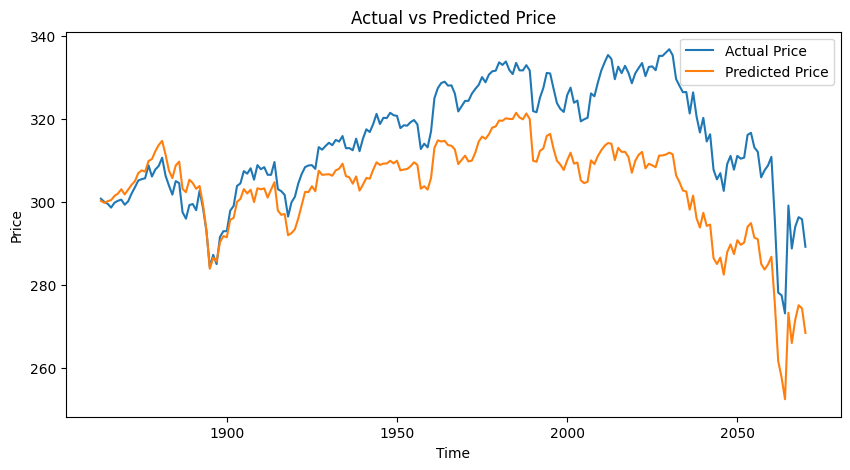

In [2359]:
plt.figure(figsize=(10, 5))
plt.plot(check_df['price_actual'], label='Actual Price')
plt.plot(check_df['price_predicted'], label='Predicted Price')
plt.legend()
plt.title('Actual vs Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

# Grid search

In [2361]:
xgb_param_grid = {
    'n_estimators': [200,300],
    'max_depth': [3,5,7,9],
    'learning_rate': [0.01, 0.05],
    'subsample': [0.6,0.8],
    'gamma':[0, 0.1],
    'reg_alpha':[0, 0.1],
    'colsample_bytree': [0.6, 0.8]
}

In [2362]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
# Create custom scorer to minimize MAE
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Define candidate weight scalings to search over
w_candidates = np.arange(1.0, 3.1, 0.2)  # Try from 1.0 to 3.0 in steps of 0.2

best_mae = float('inf')
best_xgb_model = None
best_w = None
best_params = None

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

for w in w_candidates:
    print(f"\n🔍 Testing weight slope: {w:.2f}")
    
    # Create weights linearly increasing from 1 to w
    num_samples = len(y_train)
    weights = np.linspace(1, w, num_samples)
    weights = weights / np.mean(weights)  # Normalize to mean=1

    # Grid search
    xgb_grid = GridSearchCV(
        xgb.XGBRegressor(n_jobs=-1, random_state=42, verbosity=0),
        param_grid=xgb_param_grid,
        cv=tscv,
        scoring=mae_scorer,
        verbose=0
    )

    xgb_grid.fit(x_train, y_train, sample_weight=weights)
    model = xgb_grid.best_estimator_

    # Evaluate on test set
    preds = model.predict(x_test)
    mae = mean_absolute_error(y_test, preds)
    print(f"→ MAE: {mae:.4f} | Best Params: {xgb_grid.best_params_}")

    if mae < best_mae:
        best_mae = mae
        best_xgb_model = model
        best_w = w
        best_params = xgb_grid.best_params_

# 🎉 Final result
print(f"\n✅ Best XGBoost Model")
print(f"MAE: {best_mae:.4f}")
print(f"Weight slope (w): {best_w}")
print(f"Hyperparameters: {best_params}")



🔍 Testing weight slope: 1.00
→ MAE: 0.2719 | Best Params: {'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 0, 'subsample': 0.8}

🔍 Testing weight slope: 1.20
→ MAE: 0.2824 | Best Params: {'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300, 'reg_alpha': 0, 'subsample': 0.8}

🔍 Testing weight slope: 1.40
→ MAE: 0.2726 | Best Params: {'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'reg_alpha': 0, 'subsample': 0.8}

🔍 Testing weight slope: 1.60
→ MAE: 0.2777 | Best Params: {'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'reg_alpha': 0.1, 'subsample': 0.6}

🔍 Testing weight slope: 1.80
→ MAE: 0.2914 | Best Params: {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'reg_alpha': 0, 'subsample': 0.8}

🔍 Testing weight slope: 2.00
→ MAE

0    28.06
1    28.06
2    28.06
3    28.06
4    28.06
Name: shiler pe, dtype: float64